<a href="https://colab.research.google.com/github/vap326/cse337/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [4]:
def epsilon_greedy(state, epsilon):
  ############ TODO ###########
  if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
  state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
  q_values = q_net(state_t)
  return q_values.argmax().item()
  ## epsilon decay is added outside for loop, in main

In [5]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/tmp/ipython-input-1929135722.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


Episode 100/5000, Epsilon: 0.606, Avg Reward (last 100): -4074.23
Episode 200/5000, Epsilon: 0.367, Avg Reward (last 100): -275.25
Episode 300/5000, Epsilon: 0.222, Avg Reward (last 100): -195.06
Episode 400/5000, Epsilon: 0.135, Avg Reward (last 100): -173.54
Episode 500/5000, Epsilon: 0.082, Avg Reward (last 100): -159.83
Episode 600/5000, Epsilon: 0.049, Avg Reward (last 100): -144.36
Episode 700/5000, Epsilon: 0.030, Avg Reward (last 100): -153.00
Episode 800/5000, Epsilon: 0.018, Avg Reward (last 100): -148.66
Episode 900/5000, Epsilon: 0.011, Avg Reward (last 100): -147.40
Episode 1000/5000, Epsilon: 0.010, Avg Reward (last 100): -150.28
Episode 1100/5000, Epsilon: 0.010, Avg Reward (last 100): -148.48
Episode 1200/5000, Epsilon: 0.010, Avg Reward (last 100): -145.49
Episode 1300/5000, Epsilon: 0.010, Avg Reward (last 100): -179.71
Episode 1400/5000, Epsilon: 0.010, Avg Reward (last 100): -150.74
Episode 1500/5000, Epsilon: 0.010, Avg Reward (last 100): -138.99
Episode 1600/5000,

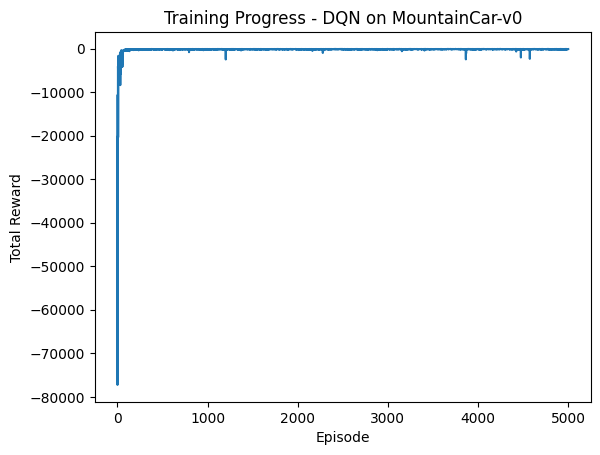

In [6]:
## MAIN Loop ###
rewards_dqn = []

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    ############ TODO ###########
    replay_buffer.append((state, action, reward, next_state, done))
    train_dqn()
    state = next_state
    total_reward += reward
  epsilon = max(epsilon_min, epsilon * epsilon_decay)
  rewards_dqn.append(total_reward)

  if (episode + 1) % 100 == 0:
      avg_reward = np.mean(rewards_dqn[-100:])
      print(f"Episode {episode+1}/{num_episodes}, "
      f"Epsilon: {epsilon:.3f}, Avg Reward (last 100): {avg_reward:.2f}")


plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress - DQN on MountainCar-v0")
plt.show()

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


/tmp/ipython-input-2258066564.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


Episode 1000/1000, Epsilon: 0.010, Avg Reward (last 100): 139.64


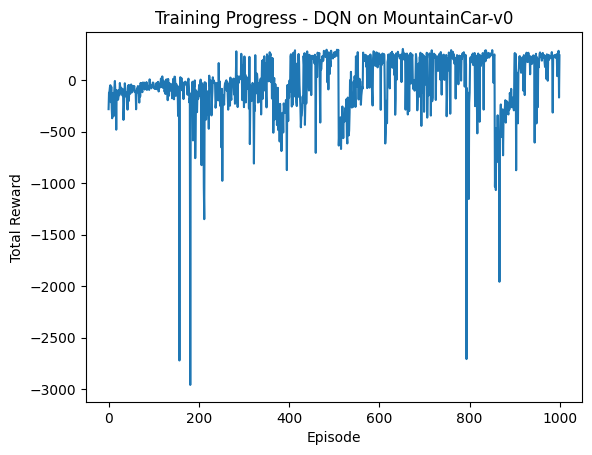

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

q_net = QNetwork(state_dim, n_actions).to(device)
target_net = QNetwork(state_dim, n_actions).to(device)
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

def epsilon_greedy(state, epsilon):
  ############ TODO ###########
  if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
  state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
  q_values = q_net(state_t)
  return q_values.argmax().item()

def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## MAIN Loop ###
rewards_dqn = []
total_steps = 0

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    ############ TODO ###########
    replay_buffer.append((state, action, reward, next_state, done))
    train_dqn()
    state = next_state
    total_reward += reward
    total_steps += 1
  if total_steps % 1000 == 0:
            target_net.load_state_dict(q_net.state_dict())
  epsilon = max(epsilon_min, epsilon * epsilon_decay)
  rewards_dqn.append(total_reward)


if (episode + 1) % 100 == 0:
    avg_reward = np.mean(rewards_dqn[-100:])
    print(f"Episode {episode+1}/{num_episodes}, "
    f"Epsilon: {epsilon:.3f}, Avg Reward (last 100): {avg_reward:.2f}")


plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress - DQN on MountainCar-v0")
plt.show()


In [9]:
pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409500 sha256=23132e30f5760d9fcb3bc2e6e461c8cfe71f6bcc0d0b1718d8cc3bc1bdf3a725
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [8]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.6 MB/s eta 0:00:00
